## Understanding the CVEs within existing Docker Images

In [1]:
import pandas as pd
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

In [2]:
# Get the outputs from the Grype scans
grype_results = os.listdir("./../grype-slim-output/")

# Sort the filenames
grype_results.sort()

# image names
images = list(set([x.split('-grype')[0] for x in grype_results]))

# Create a dictionary to hold results
results = dict()
vulns = pd.DataFrame()

# Load each Grype Scan
for file in grype_results:
    with open(f'./../grype-slim-output/{file}') as f:
        # Load the json data
        grype_data = json.load(f)

        # Append results to dictionary
        results[f"{file.replace('.json', '')}"] = len(grype_data['matches'])

        # Create a list of all the vulns within the image
        temp_vuln = [[file.replace('-grype.json', ''), 
                        x['vulnerability']['id'], 
                        x['vulnerability']['severity'], 
                        x['artifact']['name'], 
                        x['artifact']['version'], 
                        x['artifact']['type']] for x in grype_data['matches']]
        
        # Create a temp DF to hold vuln data
        temp_vuln_df = pd.DataFrame(temp_vuln, columns = ['image', 'vuln_id', 'severity', 'name', 'version', 'type'])

        # Set the image type (original/updated/cg (chainguard))
        if "-updated" in file:
            temp_vuln_df['image_type'] = "updated"
        elif "-cg" in file:
            temp_vuln_df['image_type'] = "cg"
        else:
            temp_vuln_df['image_type'] = "original"

        # Concat the version data back to the complete version DF
        vulns = pd.concat([vulns, temp_vuln_df])

# create a dict and DF to hold SBOM and versions data
sboms = dict()
versions = pd.DataFrame()

# Load each SBOM
for file in os.listdir("./../syft-slim-output/"):
    with open(f'./../syft-slim-output/{file}') as f:
        # Load the json data
        sbom = json.load(f)

        # Append results to dictionary
        sboms[f"{file.replace('.json', '')}"] = len(sbom['artifacts'])

        # Create a list of all the packages within the image
        temp_ver = [[file.replace('-sbom.json', ''), 
                        x['id'], 
                        x['name'], 
                        x['version'], 
                        x['type']] for x in sbom['artifacts']]
        # Create a temp DF to hold data
        temp_ver_df = pd.DataFrame(temp_ver, columns = ['image', 'id', 'name', 'version', 'type'])

        # Set the image type (original/updated/cg (chainguard))
        if "-updated" in file:
            temp_ver_df['image_type'] = "updated"
        elif "-cg" in file:
            temp_ver_df['image_type'] = "cg"
        else:
            temp_ver_df['image_type'] = "original"

        # Concat the version data back to the complete version DF
        versions = pd.concat([versions, temp_ver_df])

In [3]:
# Get the outputs from the CG Grype scans
grype_results = os.listdir("./../grype-output/")

# Sort the filenames
grype_results.sort()

# image names
images = list(set([x.split('-')[0] for x in grype_results if "-cg" in x]))

# Create a dictionary to hold results
# results = dict()
# vulns = pd.DataFrame()

# Load each Grype Scan
for file in grype_results:
    with open(f'./../grype-output/{file}') as f:
        if "-cg" in file:
            # Load the json data
            grype_data = json.load(f)

            # Append results to dictionary
            results[f"{file.replace('.json', '')}"] = len(grype_data['matches'])

            # Create a list of all the vulns within the image
            temp_vuln = [[file.replace('-grype.json', ''), 
                            x['vulnerability']['id'], 
                            x['vulnerability']['severity'], 
                            x['artifact']['name'], 
                            x['artifact']['version'], 
                            x['artifact']['type']] for x in grype_data['matches']]
            
            # Create a temp DF to hold vuln data
            temp_vuln_df = pd.DataFrame(temp_vuln, columns = ['image', 'vuln_id', 'severity', 'name', 'version', 'type'])

            # Set the image type (original/updated/cg (chainguard))
            if "-cg" in file:
                temp_vuln_df['image_type'] = "cg"


            # Concat the version data back to the complete version DF
            vulns = pd.concat([vulns, temp_vuln_df])

# Load each SBOM
for file in os.listdir("./../syft-output/"):
    with open(f'./../syft-output/{file}') as f:
        if "-cg" in file:
            # Load the json data
            sbom = json.load(f)

            # Append results to dictionary
            sboms[f"{file.replace('.json', '')}"] = len(sbom['artifacts'])

            # Create a list of all the packages within the image
            temp_ver = [[file.replace('-sbom.json', ''), 
                            x['id'], 
                            x['name'], 
                            x['version'], 
                            x['type']] for x in sbom['artifacts']]
            # Create a temp DF to hold data
            temp_ver_df = pd.DataFrame(temp_ver, columns = ['image', 'id', 'name', 'version', 'type'])

            # Set the image type (original/updated/cg (chainguard))
            if "-cg" in file:
                temp_ver_df['image_type'] = "cg"

            # Concat the version data back to the complete version DF
            versions = pd.concat([versions, temp_ver_df])

## How many packages appear in an image?

We can see this from the SBOM

In [4]:
print(f"Unique Images: {len(images)}\n")
print(f"Packages per image: \n{versions[versions['image_type']=='original'].image.value_counts()}\n")
print(f"Package average: {versions[versions['image_type']=='original'].image.value_counts().mean()} ")

Unique Images: 0

Packages per image: 
image
traefik              300
node:alpine          270
postgres:alpine       49
python:alpine         43
php:zts-alpine        40
rabbitmq:alpine       28
memcached:alpine      21
redis:alpine          20
nginx:alpine-slim     20
Name: count, dtype: int64

Package average: 87.88888888888889 


In [5]:
# set colors for package types
print(sns.color_palette("colorblind").as_hex())

package_colors = {
    'deb': '#0173b2', 
    'go-module': '#de8f05', 
    'apk': '#029e73', 
    'binary': '#d55e00', 
    'java-archive': '#cc78bc', 
    'npm': '#ca9161', 
    'python': '#fbafe4'}

sns.color_palette("colorblind")

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

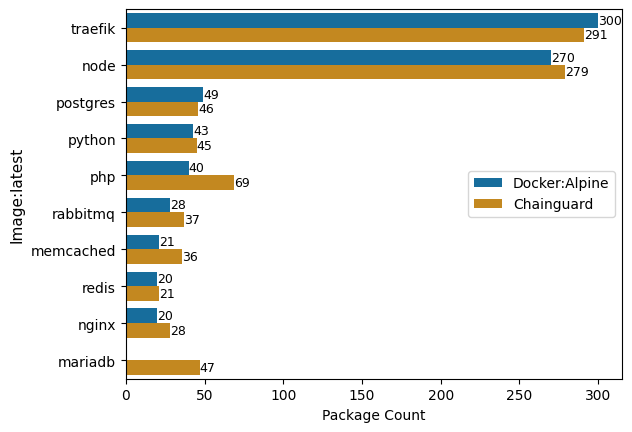

In [6]:
# generate package counts for original Docker image
packages = versions[(versions['image_type']=='original')&(versions['type']!="")].image.value_counts().reset_index(drop=False)
packages["image_type"] = "Docker:Alpine"
# Remove extra alpline from image so we can plot together
packages['image'] = packages.apply(lambda x: x['image'].split(":")[0], axis=1)

# generate package counts for Chainguard image
cg_packages = versions[(versions['image_type']=='cg')&(versions['type']!="")].image.value_counts().reset_index(drop=False)
cg_packages["image_type"] = "Chainguard"
# Remove -cg from image so we can plot together
cg_packages['image'] = cg_packages.apply(lambda x: x['image'].replace("-cg", ""), axis=1)

# combine the packages to a single DF
combined_packages = pd.concat([packages, cg_packages]).reset_index(drop=True)

# generate the barplot
ax = sns.barplot(
    data=combined_packages, x="count", y="image", hue="image_type",
    palette="colorblind"
)

# Add package counts to each bar
for i in ax.containers:
    ax.bar_label(i, fontsize=9)

# Set label size/location
ax.legend(loc='best', fontsize=10)

# Adjust x/y labels
plt.ylabel('Image:latest', fontsize=11)
plt.xlabel('Package Count', fontsize=10)
plt.show()

## What type of packages exist in the image?

### Docker

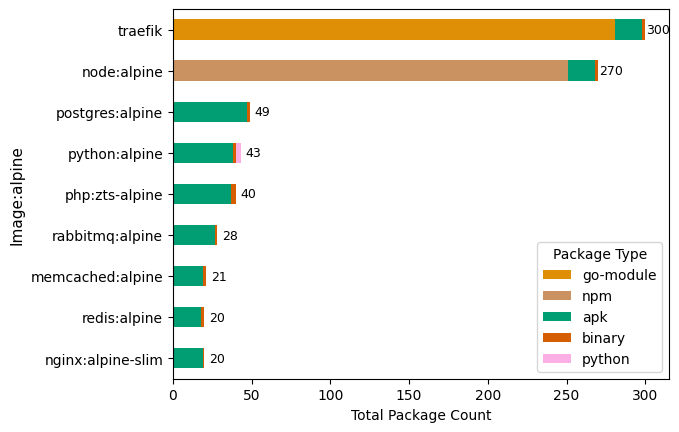

In [7]:
# generate package counts for original Docker image
pack_types = versions[(versions['image_type']=='original')&(versions['type']!="")].groupby(["type", "image"]).agg("count").reset_index(drop=False)

# pivot to make a clean DF
pack_types_pivot = pack_types.pivot(index='image', columns='type', values='id')

# set column order based on the most common types of packages
column_order = ['go-module', 'npm', 'apk', 'binary', 'python']

# set the column colors
column_color = [package_colors[x] for x in column_order]

# Fille nans with 0
pack_types_pivot = pack_types_pivot.fillna(0)

# Create a totals package
pack_types_pivot['total'] = pack_types_pivot.sum(axis=1, numeric_only=True)

# sort by totals
pack_types_pivot = pack_types_pivot.sort_values("total")

# plot the stacked bar
ax = pack_types_pivot[column_order].plot(kind='barh', stacked=True, color=column_color)

# Add package counts to each bar
for i, total in enumerate(pack_types_pivot["total"].values.tolist()):
  ax.text(total+8, i-0.09, round(total),
          ha = 'center', color = 'black', fontsize='9')

ax.legend(title='Package Type')

# Adjust x/y labels
plt.ylabel('Image:alpine', fontsize=11)
plt.xlabel('Total Package Count', fontsize=10)
plt.show()

In [8]:
vulns.type.value_counts()

type
binary       24
apk          19
go-module    18
python        2
Name: count, dtype: int64

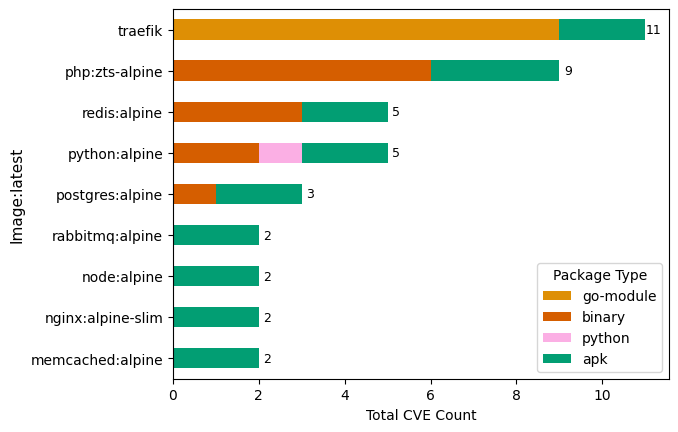

In [9]:
# generate package counts for original Docker image
vuln_types = vulns[(vulns['image_type']=='original')&(vulns['type']!="")].groupby(["type", "image"]).agg("count").reset_index(drop=False)

alpine_vuln_images = list(vuln_types.image.drop_duplicates())

# pivot to make a clean DF
vuln_types_pivot = vuln_types.pivot(index='image', columns='type', values='vuln_id')

# set column order based on the most common types of packages
column_order = ['go-module', 'binary', 'python', 'apk']

# set the column colors
column_color = [package_colors[x] for x in column_order]

# Fille nans with 0
vuln_types_pivot = vuln_types_pivot.fillna(0)

# Create a totals package
vuln_types_pivot['total'] = vuln_types_pivot.sum(axis=1, numeric_only=True)

# sort by totals
vuln_types_pivot = vuln_types_pivot.sort_values("total")

# plot the stacked bar
ax = vuln_types_pivot[column_order].plot(kind='barh', stacked=True, color=column_color)

# Add package counts to each bar
for i, total in enumerate(vuln_types_pivot["total"].values.tolist()):
  ax.text(total+0.2, i-0.09, round(total),
          ha = 'center', color = 'black', fontsize='9')

ax.legend(title='Package Type')

# Adjust x/y labels
plt.ylabel('Image:latest', fontsize=11)
plt.xlabel('Total CVE Count', fontsize=10)
plt.show()

## How many vulns appear per image?

In [10]:
print(f"Unique Images: {len(images)}\n")
print(f"Vulns per image: \n{vulns[vulns['image_type']=='original'].image.value_counts()}\n")
print(f"Unique CVEs")

Unique Images: 0

Vulns per image: 
image
traefik              11
php:zts-alpine        9
python:alpine         5
redis:alpine          5
postgres:alpine       3
memcached:alpine      2
nginx:alpine-slim     2
node:alpine           2
rabbitmq:alpine       2
Name: count, dtype: int64

Unique CVEs


### What type of packages are these vulnerabilities appearing in? 

Majority of the vulnerabilities are appearing in Debian packages. So how do you update Debian packages?

### CVE count for original Docker image and Updated Docker image

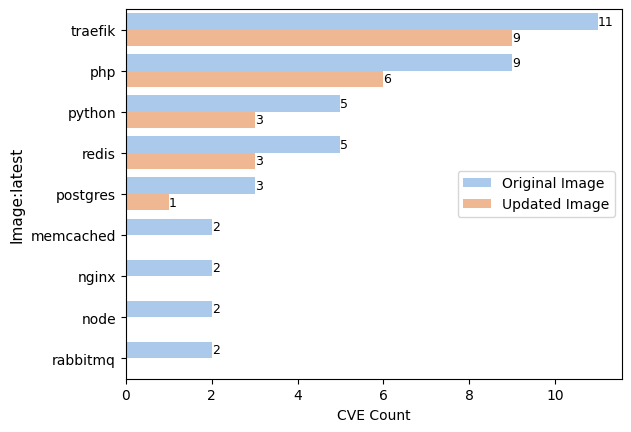

In [11]:
# generate package counts for original Docker image
packages = vulns[(vulns['image_type']=='original')&(vulns['type']!="")].image.value_counts().reset_index(drop=False)
packages["image_type"] = "Original Image"
# Remove extra alpline from image so we can plot together
packages['image'] = packages.apply(lambda x: x['image'].split(":")[0], axis=1)
# Remove extra alpline from image so we can plot together
packages['image'] = packages.apply(lambda x: x['image'].split("-grype")[0], axis=1)

# generate package counts for Chainguard image
packages_updated = vulns[(vulns['image_type']=='updated')&(vulns['type']!="")].image.value_counts().reset_index(drop=False)
packages_updated["image_type"] = "Updated Image"
# Remove -cg from image so we can plot together
packages_updated['image'] = packages_updated.apply(lambda x: x['image'].replace("-updated", ""), axis=1)
# Remove extra alpline from image so we can plot together
packages_updated['image'] = packages_updated.apply(lambda x: x['image'].split(":")[0], axis=1)
# Remove extra alpline from image so we can plot together
packages_updated['image'] = packages_updated.apply(lambda x: x['image'].split("-grype")[0], axis=1)

# # generate package counts for Chainguard image
# packages_cg = vulns[(vulns['image_type']=='cg')&(vulns['type']!="")].image.value_counts().reset_index(drop=False)
# packages_cg["image_type"] = "Updated Image"
# # Remove -cg from image so we can plot together
# packages_cg['image'] = packages_updated.apply(lambda x: x['image'].replace("-updated", ""), axis=1)

# combine the packages to a single DF
combined_packages = pd.concat([packages, packages_updated]).reset_index(drop=True)

# generate the barplot
ax = sns.barplot(
    data=combined_packages, x="count", y="image", hue="image_type",
    palette="pastel"
)

# Add package counts to each bar
for i in ax.containers:
    ax.bar_label(i, fontsize=9)

# Set label size/location
ax.legend(loc='best', fontsize=10)

# Adjust x/y labels
plt.ylabel('Image:latest', fontsize=11)
plt.xlabel('CVE Count', fontsize=10)
plt.show()

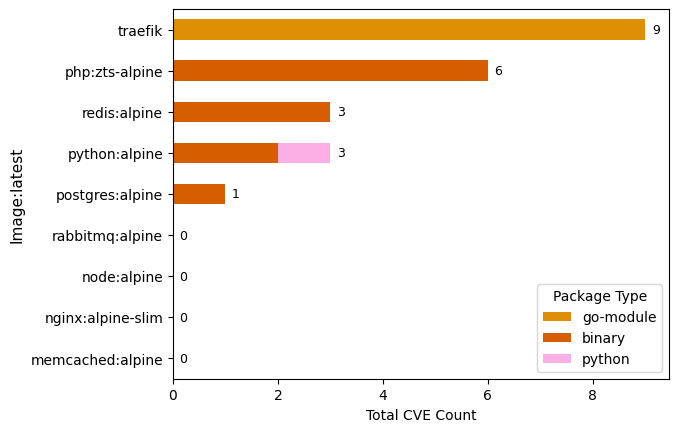

In [12]:
# generate package counts for original Docker image
vuln_types_update = vulns[(vulns['image_type']=='updated')&(vulns['type']!="")].groupby(["type", "image"]).agg("count").reset_index(drop=False)
# vuln_types['image'] = vuln_types.apply(lambda x: x['image'].split(":")[0], axis=1)
# Remove extra alpline from image so we can plot together
vuln_types_update['image'] = vuln_types_update.apply(lambda x: x['image'].split("-grype")[0], axis=1)

# pivot to make a clean DF
vuln_types_pivot_update = vuln_types_update.pivot(index='image', columns='type', values='vuln_id')

for image in alpine_vuln_images:
  if image not in list(vuln_types_pivot_update.index):
    temp_df = pd.DataFrame([[0,0,0]], columns=['binary', 'go-module', 'python'], index=[image])
    vuln_types_pivot_update = pd.concat([vuln_types_pivot_update, temp_df])

# set column order based on the most common types of packages
column_order = ['go-module', 'binary', 'python']

# set the column colors
column_color = [package_colors[x] for x in column_order]

# Fille nans with 0
vuln_types_pivot_update = vuln_types_pivot_update.fillna(0)

# Create a totals package
vuln_types_pivot_update['total'] = vuln_types_pivot_update.sum(axis=1, numeric_only=True)

# sort by totals
vuln_types_pivot_update = vuln_types_pivot_update.sort_values("total")

# plot the stacked bar
ax = vuln_types_pivot_update[column_order].plot(kind='barh', stacked=True, color=column_color)

# Add package counts to each bar
for i, total in enumerate(vuln_types_pivot_update["total"].values.tolist()):
  ax.text(total+0.2, i-0.09, round(total),
          ha = 'center', color = 'black', fontsize='9')

ax.legend(title='Package Type', loc=4)

# Adjust x/y labels
plt.ylabel('Image:latest', fontsize=11)
plt.xlabel('Total CVE Count', fontsize=10)
plt.show()

In [13]:
temp_df = pd.DataFrame([[0, 0, 0, 0]], columns=['binary', 'go-module', 'python', 'total'], index=["test"])
pd.concat([vuln_types_pivot, temp_df])

,apk,binary,go-module,python,total
memcached:alpine,2.0,0.0,0.0,0.0,2.0
nginx:alpine-slim,2.0,0.0,0.0,0.0,2.0
node:alpine,2.0,0.0,0.0,0.0,2.0
rabbitmq:alpine,2.0,0.0,0.0,0.0,2.0
postgres:alpine,2.0,1.0,0.0,0.0,3.0
python:alpine,2.0,2.0,0.0,1.0,5.0
redis:alpine,2.0,3.0,0.0,0.0,5.0
php:zts-alpine,3.0,6.0,0.0,0.0,9.0
traefik,2.0,0.0,9.0,0.0,11.0
test,NaN,0.0,0.0,0.0,0.0


### Overlap between packages

Packages between CG and Docker image

In [14]:
vuln_packages = vulns[(vulns['image_type']=='original')&(vulns['type']!="")].reset_index(drop=True)
vuln_packages['vuln_package'] = True

original_packages = versions[(versions['image_type']=='original')&(versions['type']!="")].reset_index(drop=True)
original_packages["image_type"] = "Docker"

cg_packages = versions[(versions['image_type']=='cg')&(versions['type']!="")].reset_index(drop=True)
cg_packages["image_type"] = "Chainguard"
# Rename the package version, this is the comparison
cg_packages = cg_packages.rename(columns={'version': 'cg_version'})
# Remove -cg from image so we can plot together
cg_packages['image'] = cg_packages.apply(lambda x: x['image'].replace("-cg", ""), axis=1)

# get the matching packages
matching_packages = pd.merge(original_packages[['image', 'name', 'version']],
                             cg_packages[['image', 'name', 'cg_version']],
                             on=['image', 'name'],
                             how='inner').drop_duplicates()

matching_packages = pd.merge(matching_packages,
                             vuln_packages,
                             on=['image', 'name'],
                             how='inner')


cg_matching_vuln_packages = pd.merge(cg_packages[['name', 'cg_version']].drop_duplicates(),
                             vuln_packages[['name', 'version']].drop_duplicates(),
                             on=['name'],
                             how='inner').drop_duplicates()

unique_vuln_packages = vuln_packages[['name', 'type', 'version']].drop_duplicates()
unique_vuln_packages['vuln'] = True
print(f"Unique vuln packages (Docker original): {len(unique_vuln_packages)}")
print(f"Unique Docker packages: {len(original_packages[['name']].drop_duplicates())}")
print(f"Unique CG packages: {len(cg_packages[['name']].drop_duplicates())}")
overlap_packages = pd.merge(cg_packages[['name', 'type', 'cg_version']].drop_duplicates(), 
                            original_packages[['name', 'type', 'version']].drop_duplicates(), 
                            on=['name', 'type'],
                            how='inner')
print(f"Package overlap: {len(overlap_packages)}")

overlap_vuln_package = pd.merge(overlap_packages, 
                            unique_vuln_packages[['name', 'vuln']].drop_duplicates(), 
                            on="name",
                            how='inner')

print(f"Package vuln overlap: {len(overlap_vuln_package)}")


Unique vuln packages (Docker original): 14
Unique Docker packages: 583
Unique CG packages: 563
Package overlap: 564
Package vuln overlap: 10
